# Phase 4 Project: Sentiment Analysis of SXSW Tech Tweets
## 1. Introduction
The goal of this project is to build a Natural Language Processing (NLP) model that can classify the sentiment of tweets directed at Apple and Google products.

**Dataset:** Brands and Product Emotions (Crowdsourced via CrowdFlower)  
**Context:** Tweets collected during the 2011 SXSW conference.

In [1]:
# IMPORTING ALL THE LIBRARIES REQUIRED 

import pandas as pd              # dataframes
import numpy as np               # arrays
import re                        # regex
import nltk                      # NLP tools
from nltk.corpus import stopwords        # common words
from nltk.stem import WordNetLemmatizer  # lemmatizer
import matplotlib.pyplot as plt  # plotting
import seaborn as sns            # styled plots
import warnings                  # warnings
warnings.filterwarnings('ignore') # hide warnings
%matplotlib inline               
sns.set_theme(style="whitegrid") # plot theme
%pip install wordcloud           
from wordcloud import WordCloud  # word clouds
import matplotlib.pyplot as plt  # plotting
from sklearn.model_selection import train_test_split  # split data
from sklearn.preprocessing import LabelEncoder        # encode labels
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.pipeline import Pipeline                # ML pipeline
from sklearn.metrics import classification_report, confusion_matrix # evaluation
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.pipeline import Pipeline                # pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay # confusion matrix
%pip -q install xgboost           
from sklearn.model_selection import GridSearchCV     # hyperparameter tuning
from xgboost import XGBClassifier # XGBoost model
import joblib                    # save models


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load the dataset 
file_path = 'Data/judge-1377884607_tweet_product_company.csv'
# encode due to special characters
df = pd.read_csv(file_path, encoding='latin1')
# check info and top 5 rows
print("Dataset Dimensions:", df.shape)
df.head()

Dataset Dimensions: (9093, 3)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# rename columns
df.columns = ['tweet_text', 'product_target', 'sentiment']
df.head()

,tweet_text,product_target,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# check missing values 
print("Missing Values Count")
print(df.isna().sum())

# check duplicates
duplicates = df.duplicated(subset=['tweet_text']).sum()
print(f"\nDuplicate tweets found: {duplicates}")
# remove duplicated tweets
df = df.drop_duplicates(subset=['tweet_text'])
 
df.head()

Missing Values Count
tweet_text           1
product_target    5802
sentiment            0
dtype: int64

Duplicate tweets found: 27


,tweet_text,product_target,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# create a function to group Google and Apple products
# this function also reduces missing values in the product category
def impute_product(row):
    text = str(row['tweet_text']).lower()
    if pd.isna(row['product_target']):
        if 'iphone' in text or 'apple' in text or 'ipad' in text:
            return 'Apple'
        if 'google' in text or 'android' in text:
            return 'Google'
    return row['product_target']

df['product_target'] = df.apply(impute_product, axis=1)


# check for missing values
print("Missing Values Count")
print(df.isna().sum())

Missing Values Count
tweet_text          1
product_target    760
sentiment           0
dtype: int64


## 2. Exploratory Data Analysis
In this section, we explore the structure of our data and analyze the distribution of our target classes.

### Key Questions:
* How many tweets are directed at Apple vs. Google?
* Is there a significant class imbalance in the sentiment labels?
* What are the most common words used in 'Positive' vs 'Negative' tweets?

Unique Sentiment Labels:
sentiment
No emotion toward brand or product    5373
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64


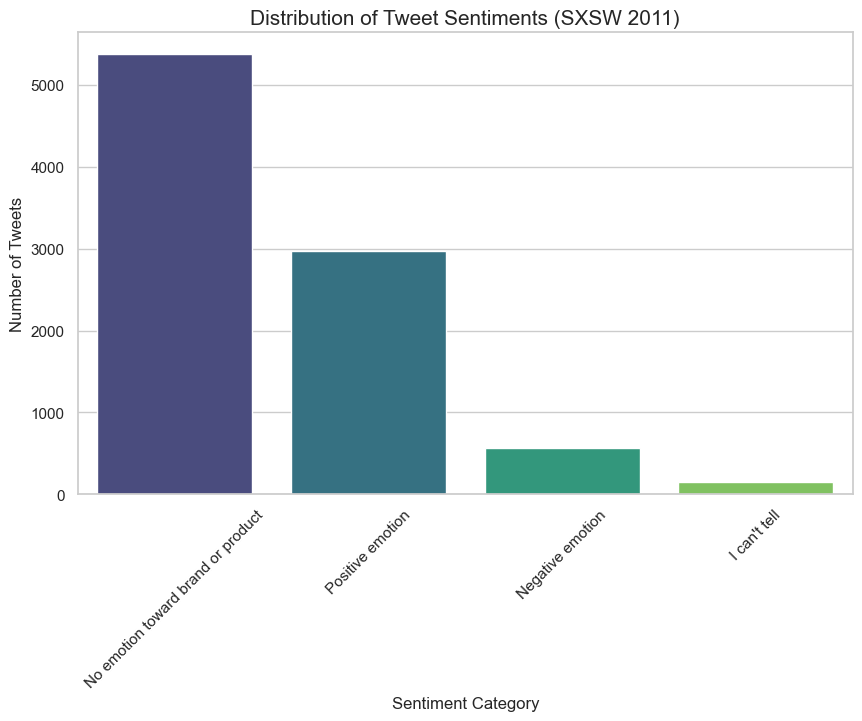


-Sentiment Percentages -
sentiment
No emotion toward brand or product    59.27%
Positive emotion                      32.74%
Negative emotion                       6.28%
I can't tell                           1.72%
Name: proportion, dtype: object


In [6]:
# unique values - sentiment column
print("Unique Sentiment Labels:")
print(df['sentiment'].value_counts())

# visualize distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='viridis', order=df['sentiment'].value_counts().index)

plt.title('Distribution of Tweet Sentiments (SXSW 2011)', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# calculate percentages
sentiment_pct = df['sentiment'].value_counts(normalize=True) * 100
print("\n-Sentiment Percentages -")
print(sentiment_pct.map('{:.2f}%'.format))

Unique Sentiment Labels:
sentiment
No emotion toward brand or product    5373
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64


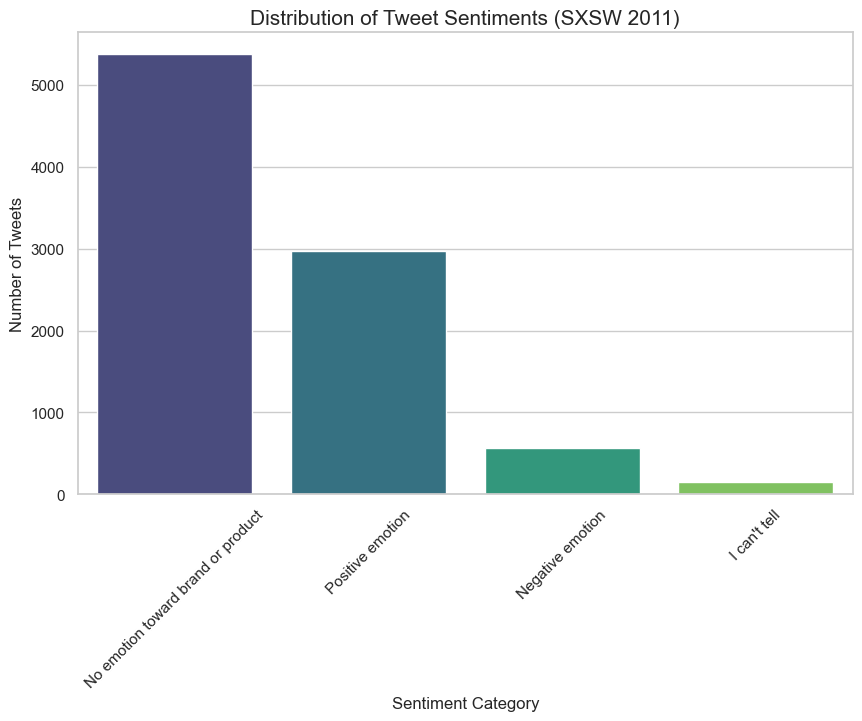


-Sentiment Percentages -
sentiment
No emotion toward brand or product    59.27%
Positive emotion                      32.74%
Negative emotion                       6.28%
I can't tell                           1.72%
Name: proportion, dtype: object


In [7]:
# unique values - sentiment column
print("Unique Sentiment Labels:")
print(df['sentiment'].value_counts())

# visualize distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='viridis', order=df['sentiment'].value_counts().index)

plt.title('Distribution of Tweet Sentiments (SXSW 2011)', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# calculate percentages
sentiment_pct = df['sentiment'].value_counts(normalize=True) * 100
print("\n-Sentiment Percentages -")
print(sentiment_pct.map('{:.2f}%'.format))

## 3. Data Cleaning & Text Preprocessing
Raw tweets are "noisy." To prepare the text for modeling, we must:
1. **Lowercase** all text.
2. **Remove Stopwords** (common words like "the", "and").
3. **Remove Noise:** Mentions (@), Hashtags (#), and URLs.
4. **Tokenization:** Break sentences into individual words.
5. **Lemmatization:** Reduce words to their root form (e.g., "running" to "run").


In [8]:
# download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # wordnet
# initialize text preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_tweet(text):
    # lowercase text
    text = str(text).lower()
    
    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # remove mentions and hashtag symbols
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)
    
    # remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # tokenize, remove Stopwords, and lemmatize
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    
    return " ".join(cleaned_tokens)

# apply cleaning function
df['cleaned_tweet'] = df['tweet_text'].apply(clean_tweet)

# Preview the transformation
print("Original Tweet:", df['tweet_text'].iloc[0])
print("Cleaned Tweet: ", df['cleaned_tweet'].iloc[0])
df[['tweet_text', 'cleaned_tweet']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...


Original Tweet: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Cleaned Tweet:  g iphone hr tweeting riseaustin dead need upgrade plugin station sxsw


,tweet_text,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphone hr tweeting riseaustin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri sxsw marissa mayer google tim ...


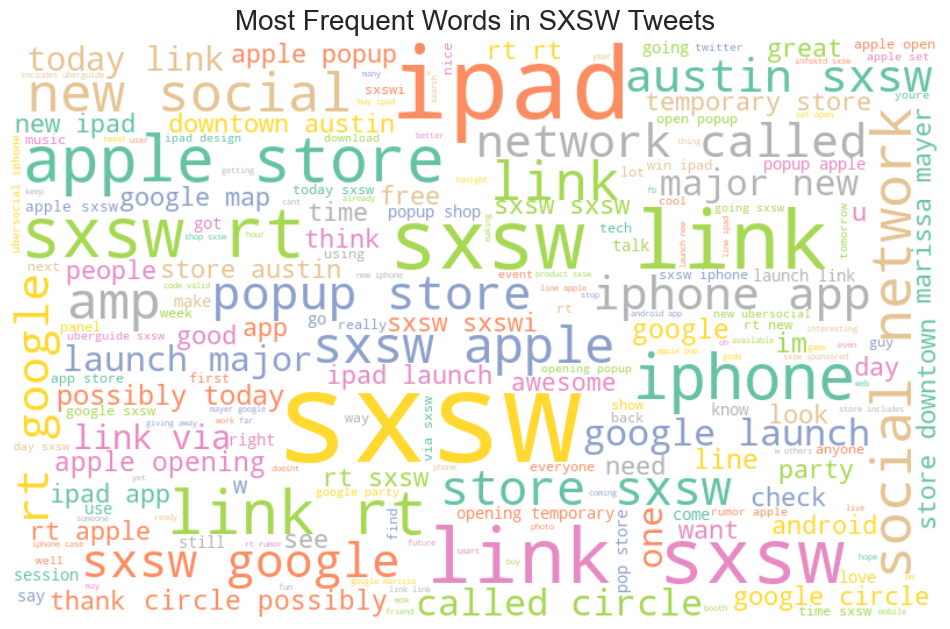

In [9]:
# combine all cleaned tweets into one massive string
all_words = ' '.join(df['cleaned_tweet'].dropna()) # drop NaN values

# initialize and generate wordcloud
wordcloud = WordCloud(
    width=800, 
    height=500, 
    background_color='white', 
    max_font_size=110, 
    colormap='Set2'
).generate(all_words)

# plot the WordCloud to check common words
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Most Frequent Words in SXSW Tweets', fontsize=20)
plt.show()

## 4. Data Preparation for Modeling
Before training our models, we must convert our categorical labels into a format the computer can understand and split our data into training and testing sets.

**Key Steps:**
* **Label Encoding:** Converting "Positive", "Negative", and "Neutral" into integers (0, 1, 2).
* **Train-Test Split:** We will use an 80/20 split. 
* **Stratification:** Because our classes are imbalanced, we use `stratify=y` to ensure both the training and testing sets have the same ratio of sentiments.

In [10]:
# encode the target (Sentiment) into numbers
encode = LabelEncoder()
# creates a mapping: Negative=0, Neutral=1, Positive=2
df['target'] = encode.fit_transform(df['sentiment'])

# define X and y
X = df['cleaned_tweet']
y = df['target']

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 7252
Testing samples: 1814


## 5. Baseline Model: Multinomial Naive Bayes
For our first iteration, we establish a **Baseline Model**. We use a **TF-IDF Vectorizer** (Term Frequency-Inverse Document Frequency) to convert our text into numbers.

**Why this model?**
* **Naive Bayes** is computationally efficient and often performs surprisingly well on text classification tasks.
* **TF-IDF** helps by penalizing common words (like "the") and boosting words that are more unique to specific sentiments (like "awesome" or "fail").

In [11]:
# create a Pipeline
baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# train the model
baseline_model.fit(X_train, y_train)

# make predictions
y_pred = baseline_model.predict(X_test)

# model evaluation
print("Baseline Model Classification Report")
print(classification_report(y_test, y_pred, target_names=encode.classes_))

Baseline Model Classification Report
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       1.00      0.02      0.03       114
No emotion toward brand or product       0.64      0.96      0.77      1075
                  Positive emotion       0.73      0.25      0.37       594

                          accuracy                           0.65      1814
                         macro avg       0.59      0.31      0.29      1814
                      weighted avg       0.68      0.65      0.58      1814



## 6. Model Iteration: Random Forest / Gradient Boosting
The baseline model often struggles with imbalanced data. In this section, we attempt to improve performance by using more complex ensemble methods like **Random Forest** or **XGBoost**.

**Improvements to explore:**
* **Hyperparameter Tuning:** Using `GridSearchCV` to find the best settings.
* **Handling Imbalance:** Experimenting with class weights

-- Random Forest Model Classification Report --
                                    precision    recall  f1-score   support

                      I can't tell       0.12      0.03      0.05        31
                  Negative emotion       0.59      0.24      0.34       114
No emotion toward brand or product       0.67      0.84      0.75      1075
                  Positive emotion       0.60      0.42      0.49       594

                          accuracy                           0.65      1814
                         macro avg       0.50      0.38      0.41      1814
                      weighted avg       0.63      0.65      0.63      1814



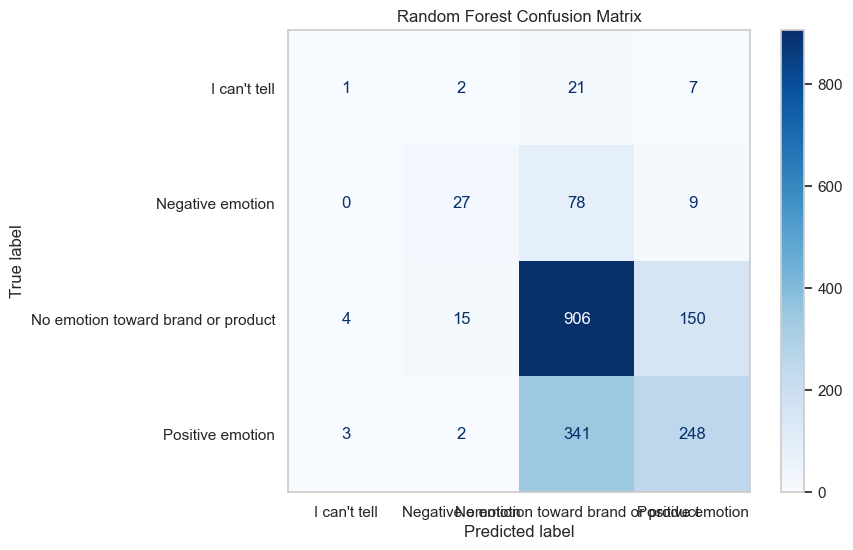

In [12]:
# define Pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000)), # limit features to prevent overfitting
    ('rf', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced', # addresses class imbalance
        n_jobs=-1 # for faster training
    ))
])

# train the model
rf_pipeline.fit(X_train, y_train)

# make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# compare with baseline
print("-- Random Forest Model Classification Report --")
# get the original names back
print(classification_report(y_test, y_pred_rf, target_names=encode.classes_))

# visualize the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test, y_test, 
                                      display_labels=encode.classes_, 
                                      cmap='Blues', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.grid(False) # clean up the vizz
plt.show()


## Model Tuning With a Validation Set and GridSearchCV (Multi-class)

Below we **add a validation split** and use **GridSearchCV** to find better hyperparameters for each model. We also train an **XGBoost classifier**, which is a strong boosting baseline for text features.

In [13]:
# create Train / Validation / Test splits
X_mc = df['cleaned_tweet']
y_mc = df['target']

# split off the test set (20%)
X_trainval_mc, X_test_mc, y_trainval_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=0.20, random_state=42, stratify=y_mc
)

# split train into train/validation
X_train_mc, X_val_mc, y_train_mc, y_val_mc = train_test_split(
    X_trainval_mc, y_trainval_mc, test_size=0.25, random_state=42, stratify=y_trainval_mc
)

print("Multi-class split sizes:")
print(f"  Train: {len(X_train_mc):,}")
print(f"  Val  : {len(X_val_mc):,}")
print(f"  Test : {len(X_test_mc):,}")

Multi-class split sizes:
  Train: 5,439
  Val  : 1,813
  Test : 1,814


In [14]:
# GridSearchCV for Multinomial Naive Bayes 

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

nb_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 2],
    'nb__alpha': [0.1, 0.5, 1.0]
}

nb_grid = GridSearchCV(
    nb_pipeline,
    param_grid=nb_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=0
)

nb_grid.fit(X_train_mc, y_train_mc)

print("Best NB params:", nb_grid.best_params_)
print("Best NB CV score (f1_macro):", nb_grid.best_score_)

# validate
y_val_pred_nb = nb_grid.predict(X_val_mc)
print("\n--- NB (Tuned) Validation Report ---")
print(classification_report(y_val_mc, y_val_pred_nb, target_names=encode.classes_))


Best NB params: {'nb__alpha': 0.1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best NB CV score (f1_macro): 0.35838719320268386

--- NB (Tuned) Validation Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.10      0.03      0.05        31
                  Negative emotion       0.59      0.19      0.29       114
No emotion toward brand or product       0.69      0.81      0.75      1075
                  Positive emotion       0.55      0.47      0.51       593

                          accuracy                           0.65      1813
                         macro avg       0.48      0.38      0.40      1813
                      weighted avg       0.63      0.65      0.63      1813



In [15]:
# GridSearchCV for Random Forest

rf_pipeline_gs = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

rf_param_grid = {
    'tfidf__max_features': [2000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [200, 500],
    'rf__max_depth': [20, 30, 60],
    'rf__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    rf_pipeline_gs,
    param_grid=rf_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=0
)

rf_grid.fit(X_train_mc, y_train_mc)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV score (f1_macro):", rf_grid.best_score_)

# validate
y_val_pred_rf = rf_grid.predict(X_val_mc)
print("\n--- RF (Tuned) Validation Report ---")
print(classification_report(y_val_mc, y_val_pred_rf, target_names=encode.classes_))


Best RF params: {'rf__max_depth': 60, 'rf__min_samples_split': 5, 'rf__n_estimators': 500, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Best RF CV score (f1_macro): 0.3679517925877642

--- RF (Tuned) Validation Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.22      0.06      0.10        31
                  Negative emotion       0.26      0.30      0.28       114
No emotion toward brand or product       0.70      0.71      0.71      1075
                  Positive emotion       0.54      0.53      0.54       593

                          accuracy                           0.62      1813
                         macro avg       0.43      0.40      0.41      1813
                      weighted avg       0.61      0.62      0.61      1813



### XGBoost Model


In [16]:
# GridSearchCV for XGBoost 

# xgb_pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('xgb', XGBClassifier(
#         objective='multi:softprob',
#         num_class=len(encode.classes_),
#         eval_metric='mlogloss',
#         random_state=42,
#         n_jobs=-1,
#         tree_method='hist'  
#     ))
# ])

# xgb_param_grid = {
#     'tfidf__max_features': [5000],
#     'tfidf__ngram_range': [(1, 1), (1, 2)],
#     'xgb__n_estimators': [200, 500],
#     'xgb__max_depth': [3, 6],
#     'xgb__learning_rate': [0.05, 0.1],
#     'xgb__subsample': [0.8, 1.0],
#     'xgb__colsample_bytree': [0.8, 1.0]
# }

# xgb_grid = GridSearchCV(
#     xgb_pipeline,
#     param_grid=xgb_param_grid,
#     cv=3,
#     n_jobs=-1,
#     scoring='f1_macro',
#     verbose=0
# )

# xgb_grid.fit(X_train_mc, y_train_mc)

# print("Best XGB params:", xgb_grid.best_params_)
# print("Best XGB CV score (f1_macro):", xgb_grid.best_score_)

# # validate
# y_val_pred_xgb = xgb_grid.predict(X_val_mc)
# print("\n--- XGBoost (Tuned) Validation Report ---")
# print(classification_report(y_val_mc, y_val_pred_xgb, target_names=encode.classes_))


In [17]:
# comparison on the multi-class test set using the tuned models

print("Multi-class Test Set Results (Tuned Models)")

y_test_pred_nb = nb_grid.predict(X_test_mc)
print("\n--- Tuned NB Test Report ---")
print(classification_report(y_test_mc, y_test_pred_nb, target_names=encode.classes_))

y_test_pred_rf2 = rf_grid.predict(X_test_mc)
print("\n--- Tuned RF Test Report ---")
print(classification_report(y_test_mc, y_test_pred_rf2, target_names=encode.classes_))

# y_test_pred_xgb = xgb_grid.predict(X_test_mc)
# print("\n--- Tuned XGBoost Test Report ---")
# print(classification_report(y_test_mc, y_test_pred_xgb, target_names=encode.classes_))


Multi-class Test Set Results (Tuned Models)

--- Tuned NB Test Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.58      0.22      0.32       114
No emotion toward brand or product       0.68      0.82      0.75      1075
                  Positive emotion       0.58      0.46      0.51       594

                          accuracy                           0.65      1814
                         macro avg       0.46      0.37      0.39      1814
                      weighted avg       0.63      0.65      0.63      1814


--- Tuned RF Test Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.34      0.39      0.36       114
No emotion toward brand or product       0.72      0.72 